In [30]:
import os
import urllib.request
import tarfile
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [18]:
url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
file_name = "images.tar.gz"

urllib.request.urlretrieve(url, file_name)

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

os.remove(file_name)

In [21]:
def load_images(folder_path, image_size):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            image = tf.keras.preprocessing.image.load_img(
                os.path.join(folder_path, filename),
                target_size=image_size
            )
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = (image - 127.5) / 127.5
            images.append(image)
    return np.array(images)

In [23]:
def build_discriminator(input_shape):
    model = Sequential([
        Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(256, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [22]:
def build_generator(latent_dim):
    model = Sequential([
        Dense(8 * 8 * 256, input_dim=latent_dim),
        Reshape((8, 8, 256)),
        Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')
    ])
    return model

In [77]:
def train_generator(generator, discriminator, latent_dim, batch_size):
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=False)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

def train_discriminator(generator, discriminator, images, latent_dim, batch_size):
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train_gan(generator, discriminator, images, latent_dim, epochs, batch_size):
    for epoch in range(epochs):
        progress_bar = tqdm(range(len(images) // batch_size))
        for i in progress_bar:
            batch_images = images[i * batch_size: (i + 1) * batch_size]
            train_discriminator(generator, discriminator, batch_images, latent_dim, batch_size)
            train_generator(generator, discriminator, latent_dim, batch_size)
            progress_bar.set_description(f'Epoch {epoch + 1}/{epochs}')
            progress_bar.set_postfix({'disc_loss': discriminator.loss, 'gen_loss': generator.loss})

In [78]:
image_size = (64, 64)
latent_dim = 100
images = load_images("images/", image_size)

In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [80]:
generator = build_generator(latent_dim)
discriminator = build_discriminator((image_size[0], image_size[1], 3))
generator.compile(optimizer=generator_optimizer, loss=cross_entropy)
discriminator.compile(optimizer=discriminator_optimizer, loss=cross_entropy)

In [81]:
train_gan(generator, discriminator, images, latent_dim, epochs=20, batch_size=64)

Epoch 20/20: 100%|██████████| 115/115 [10:35<00:00,  5.53s/it, disc_loss=<keras.src.losses.BinaryCrossentropy object at 0x782cf14dff70>, gen_loss=<keras.src.losses.BinaryCrossentropy object at 0x782cf14dff70>]


In [123]:
def generate_images(generator, latent_dim, num_images):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = generator(noise, training=False)
    return generated_images

def visualize_original_and_generated(original_images, generated_images, num_images):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i] * 0.5 + 0.5)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(generated_images[i] * 0.5 + 0.5)
        plt.title('Generated')
        plt.axis('off')

    plt.show()

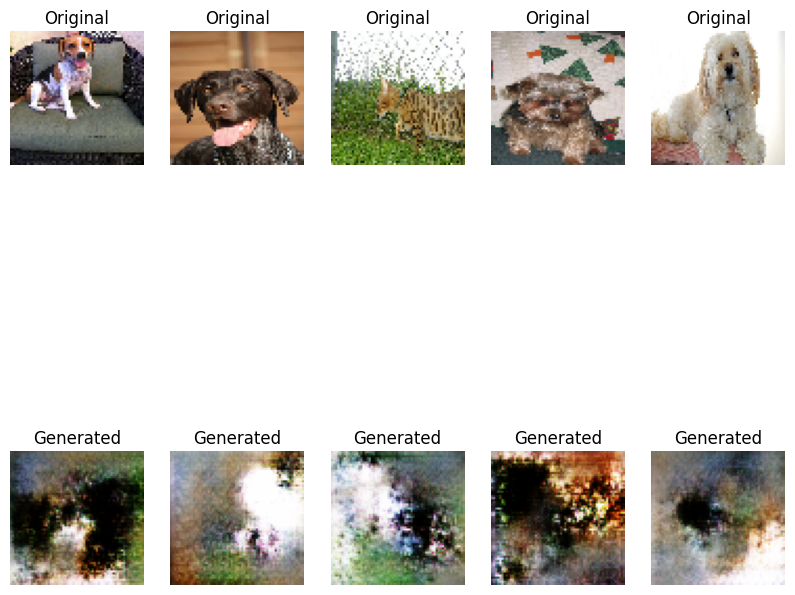

In [124]:
num_images= 5
generated_images = generate_images(generator, latent_dim, num_images)
visualize_original_and_generated(images, generated_images.numpy(), num_images)
